In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import sklearn

#Custom
from functions import import_data_and_create_master

In [ ]:
## The purpose is to create a function which can take in a date and create features from the data looking 
## back from that date aggregating at a user level, behaviour from transactiontable and all other information 
## available about the transaction downloads. 

Hard Coded for feature generator:
Metrics: 
    price(Spend)
    age_on_pltfm

Aggregation Functions:
    Transaction count : count()
    Transaction total($) : sum()
    Avg value of Transaction : mean()

Cuts/Groups:
    Time Window:
        Previous 7 days
        Previous 14 days
        Previous 30 days
        Previous 60 days
        All hist
    App Categry
    Device
    Payment Type
    Content Type

In [5]:
master=import_data_and_create_master()

In [3]:
master.dtypes

trans_dt              datetime64[ns]
content_id                    object
acct_id                       object
price                        float64
purchase_device_id             int64
year_mon_trans             period[M]
device_name                   object
app_name                      object
app_id                        object
app_category                  object
content_type                  object
act_create_dt         datetime64[ns]
payment_type                  object
year_mon_account           period[M]
age_on_pltfm                 float64
dtype: object

In [4]:
master.head()

,trans_dt,content_id,acct_id,price,purchase_device_id,year_mon_trans,device_name,app_name,app_id,app_category,content_type,act_create_dt,payment_type,year_mon_account,age_on_pltfm
0,2016-08-28,b6cf4f33e7455df4,220574a7a6a71afa,11.99,1,2016-08,iPhone,events Bildad's,61cea77b9bc843d1,Utilities,subscription,2009-08-29,PMOF,2009-08,2556.0
1,2016-09-16,71ac3e9c38ddbbba,8551f69a5015ea6a,1.99,2,2016-09,iPad,swell questionably,1f0ebd67df5846cd,Utilities,consumable,2011-05-28,PMOF,2011-05,1938.0
2,2016-08-15,776b851b916c33d1,7dedf309494a1966,0.99,2,2016-08,iPad,supperless--my Shipmates,1383e4f2f49f0f44,Games,consumable,2009-11-15,PMOF,2009-11,2465.0
3,2016-06-17,7a47ca132a8dc695,7174a81c796dcf7e,1.99,2,2016-06,iPad,unwritten hungry,8590a25d4e5c249c,Games,consumable,2009-03-01,PMOF,2009-03,2665.0
4,2016-06-13,30581219bc952dbb,35aaf59d64a677e7,11.99,2,2016-06,iPad,Turning thanked,478e10f9248b7842,Entertainment,consumable,2010-10-01,PMOF,2010-10,2082.0


### Fill nulls with 'unknown' or 'missing'

In [8]:
master.isnull().sum()


trans_dt                    0
content_id                  0
acct_id                     0
price                       0
purchase_device_id          0
year_mon_trans              0
device_name                 0
app_name              1594364
app_id                1594364
app_category          1594364
content_type          1594364
act_create_dt            2742
payment_type             2742
year_mon_account         2742
age_on_pltfm             2742
dtype: int64

In [9]:
master.fillna({'app_name':'unknown',
               'app_id':'unknown',
               'app_category':'unknown',
               'content_type':'unknown',
               'payment_type':'unknown',
               }, inplace=True)

In [10]:
master.isnull().sum()

trans_dt                 0
content_id               0
acct_id                  0
price                    0
purchase_device_id       0
year_mon_trans           0
device_name              0
app_name                 0
app_id                   0
app_category             0
content_type             0
act_create_dt         2742
payment_type             0
year_mon_account      2742
age_on_pltfm          2742
dtype: int64

### Create an example feature and then generalize it to create a function
- For every user what is the avg value of transaction over last 14 days across app category 'Utilities' on ipad for content_type consumables

In [51]:
date_of_segmentation=pd.to_datetime('2016-06-30')
master_sub=master[(master.trans_dt<=date_of_segmentation)]

In [52]:
feat_master=pd.DataFrame(index=master_sub.acct_id.unique())
feat_master.head()

""
7174a81c796dcf7e
35aaf59d64a677e7
9208426ff8cd8879
bed1f709cccd7893
d50fbbf7e279aee9


### Create indexes for all filters to subset master

In [58]:

# Index for time window
days_prev_all=[7,14,30,60,100000]
print(days_prev_all)
days_prev=14
time_window=datetime.timedelta(days_prev)
time_filter_index=(master_sub.trans_dt>(date_of_segmentation-time_window))

# Index for App Category
app_categories_all=master_sub.app_category.unique().tolist()
print(app_categories_all)
app_cat='Utilities'
app_filter_index = master_sub.app_category==app_cat

# Index for Device
devices_all = master_sub.device_name.unique().tolist()
print(devices_all)
device = 'iPad'
device_filter_index = master_sub.device_name==device

# Index for Content Type
content_all = master_sub.content_type.unique().tolist()
print(content_all)
content_type = 'consumable'
content_filter_index = master_sub.content_type==content_type

all_filters=device_filter_index & app_filter_index & time_filter_index & content_filter_index
# Number of trans in the filter
sum(all_filters)

# String to use in feature name
cuts_string='_days_'+str(days_prev)+'_app_cat_'+app_cat+'_device_'+device+'_cont_type_'+content_type
print(cuts_string)

[7, 14, 30, 60, 100000]
['Games', 'Entertainment', 'Photos & Videos', 'Utilities', 'Social Networking', 'unknown']
['iPad', 'iPhone']
['consumable', 'subscription', 'unknown']
_days_14_app_cat_Utilities_device_iPad_cont_type_consumable


### Subset master based on above index

In [54]:
master_filt=master_sub[all_filters]
master_filt.shape

(5452, 15)

### Do the Aggregation

In [55]:
all_agg_functions=['mean','count','sum']
agg_function='mean'

all_metric=['price','age_on_pltfm']
metric='price'

feat_name=str(metric+'_'+agg_function+cuts_string)
feat_df=master_filt.groupby('acct_id').agg({metric:agg_function}).rename(columns={metric:feat_name})
feat_master=feat_master.join(feat_df)

In [56]:
feat_master.head()

,price_mean_days_14_app_cat_Utilities_device_iPad_cont_type_consumable
7174a81c796dcf7e,NaN
35aaf59d64a677e7,10.99
9208426ff8cd8879,NaN
bed1f709cccd7893,5.99
d50fbbf7e279aee9,NaN


### Generalize above code to function

In [60]:
# Index for time window
print('Iterate across days_prev: '+str(days_prev_all))
app_categories_all=master_sub.app_category.unique().tolist()
print('Iterate across app_categories: '+ str(app_categories_all))
devices_all = master_sub.device_name.unique().tolist()
print('Iterate across devices: '+ str(devices_all))
content_all = master_sub.content_type.unique().tolist()
print('Iterate across content types: '+ str(content_all))


Iterate across days_prev: [7, 14, 30, 60, 100000]
Iterate across app_categories: ['Games', 'Entertainment', 'Photos & Videos', 'Utilities', 'Social Networking', 'unknown']
Iterate across devices: ['iPad', 'iPhone']
Iterate across content types: ['consumable', 'subscription', 'unknown']


In [66]:
app_categories_all=master_sub.app_category.unique().tolist()
app_categories_all.append('All')
app_categories_all

['Games',
 'Entertainment',
 'Photos & Videos',
 'Utilities',
 'Social Networking',
 'unknown',
 'All']

In [118]:
def generate_features(date_of_segmentation,dataset, days_prev_all=[7,14,30,60],all_agg_functions=['mean','count','sum'],all_metrics=['price']):
    date_of_segmentation=pd.to_datetime(date_of_segmentation)
    master_sub=dataset[(dataset.trans_dt<=date_of_segmentation)]

    feat_master=pd.DataFrame(index=master_sub.acct_id.unique())
    feat_master.head()

    # Index for time window
    #appending 100000 days to get all historical data
    days_prev_all.append(100000)
    print('Days_prev: '+str(days_prev_all))
    app_categories_all=master_sub.app_category.unique().tolist()
    app_categories_all.append('All')
    print('App_categories: '+ str(app_categories_all))
    devices_all = master_sub.device_name.unique().tolist()
    devices_all.append('All')
    print('Devices: '+ str(devices_all))
    content_all = master_sub.content_type.unique().tolist()
    content_all.append('All')
    print('Content types: '+ str(content_all))



    for days_prev in days_prev_all:
        for app_cat in app_categories_all:
            for device in devices_all:
                for content_type in content_all:
                    #Index for days_prev
                    # in case of 'All' generate a series with all True so that no filtering is done
                    time_window=datetime.timedelta(days_prev)
                    time_filter_index=np.where(days_prev=='All',~(master_sub.trans_dt.isnull()),(master_sub.trans_dt>(date_of_segmentation-time_window)))

                    # Index for App Category
                    # in case of 'All' generate a series with all True so that no filtering is done
                    app_filter_index = np.where(app_cat=='All',~(master_sub.app_category.isnull()),master_sub.app_category==app_cat)

                    # Index for Device
                    # in case of 'All' generate a series with all True so that no filtering is done
                    device_filter_index = np.where(device=='All',~(master_sub.device_name.isnull()), master_sub.device_name==device)

                    # Index for Content Type
                    # in case of 'All' generate a series with all True so that no filtering is done
                    content_filter_index =  np.where(content_type=='All',~(master_sub.content_type.isnull()), master_sub.content_type==content_type)

                    #All filters
                    all_filters=device_filter_index & app_filter_index & time_filter_index & content_filter_index

                    # String to use in feature name
                    cuts_string='_days_'+str(days_prev)+'_app_cat_'+app_cat+'_device_'+device+'_cont_type_'+content_type

                    # FILTER THE DATA
                    master_filt=master_sub[all_filters]

                    for agg_function in all_agg_functions:
                        for metric in all_metrics:
                            # Check if after filtering there are no transactions left
                            if (all_filters.sum()==0):
                                feat_name=str(metric+'_'+agg_function+cuts_string)
                                print('NO TRANSACTIONS IN THIS CUT: '+ feat_name)
                            else:
                                # AGGREGATION
                                feat_name=str(metric+'_'+agg_function+cuts_string)
                                print(feat_name)
                                feat_df=master_filt.groupby('acct_id').agg({metric:agg_function}).rename(columns={metric:feat_name})
                                feat_master=feat_master.join(feat_df)
                                print(feat_master.shape[1])
    
    print(str(feat_master.shape[1])+' features created')
    
    feat_master.reset_index().rename(columns={'index':'acct_id'}).to_csv('feat_master.csv')
    feat_master = feat_master.reset_index().rename(columns={'index':'acct_id'})
    
    return feat_master
    


In [114]:
feat_master.head()

,price_mean_days_7_app_cat_Games_device_iPad_cont_type_consumable,price_count_days_7_app_cat_Games_device_iPad_cont_type_consumable,price_sum_days_7_app_cat_Games_device_iPad_cont_type_consumable,price_mean_days_7_app_cat_Games_device_iPad_cont_type_All,price_count_days_7_app_cat_Games_device_iPad_cont_type_All,price_sum_days_7_app_cat_Games_device_iPad_cont_type_All,price_mean_days_7_app_cat_Games_device_iPhone_cont_type_consumable,price_count_days_7_app_cat_Games_device_iPhone_cont_type_consumable,price_sum_days_7_app_cat_Games_device_iPhone_cont_type_consumable,price_mean_days_7_app_cat_Games_device_iPhone_cont_type_All,...,price_sum_days_100000_app_cat_All_device_All_cont_type_consumable,price_mean_days_100000_app_cat_All_device_All_cont_type_subscription,price_count_days_100000_app_cat_All_device_All_cont_type_subscription,price_sum_days_100000_app_cat_All_device_All_cont_type_subscription,price_mean_days_100000_app_cat_All_device_All_cont_type_unknown,price_count_days_100000_app_cat_All_device_All_cont_type_unknown,price_sum_days_100000_app_cat_All_device_All_cont_type_unknown,price_mean_days_100000_app_cat_All_device_All_cont_type_All,price_count_days_100000_app_cat_All_device_All_cont_type_All,price_sum_days_100000_app_cat_All_device_All_cont_type_All
7174a81c796dcf7e,NaN,NaN,NaN,NaN,NaN,NaN,12.74,4.0,50.96,12.74,...,195.75,5.99,1.0,5.99,1.992500,4.0,7.97,6.990333,30,209.71
35aaf59d64a677e7,1.99,1.0,1.99,1.99,1.0,1.99,15.19,5.0,75.95,15.19,...,343.63,7.99,2.0,15.98,3.132857,7.0,21.93,8.294348,46,381.54
9208426ff8cd8879,8.99,1.0,8.99,8.99,1.0,8.99,NaN,NaN,NaN,NaN,...,167.76,6.19,5.0,30.95,3.490000,4.0,13.96,6.444545,33,212.67
bed1f709cccd7893,6.99,1.0,6.99,6.99,1.0,6.99,16.99,3.0,50.97,16.99,...,266.67,8.99,1.0,8.99,3.490000,6.0,20.94,7.415000,40,296.60
d50fbbf7e279aee9,5.99,2.0,11.98,5.99,2.0,11.98,28.99,2.0,57.98,28.99,...,353.66,3.79,5.0,18.95,2.561429,7.0,17.93,8.490000,46,390.54


### Create user level dataset

In [3]:
date_of_segmentation=pd.to_datetime('2016-06-30')

In [6]:
# create age on platform on day of segmentation
user_dtst=master.groupby('acct_id')\
          .agg(age_on_platform= ('trans_dt' , lambda x: np.mean(x-date_of_segmentation).days)).reset_index()
user_dtst.head()



,acct_id,age_on_platform
0,00028709c8d435ff,27
1,0005a4d77127fde7,29
2,0005c296f2605c08,24
3,00082ad3dc50a70d,27
4,00085ff73786df4d,29


### Generate features

In [11]:
feat_data=generate_features(date_of_segmentation,master)
# feat_data=pd.read_csv('feat_master.csv')
feat_data.head()

,index,price_mean_days_7_app_cat_Games_device_iPad_cont_type_consumable,price_count_days_7_app_cat_Games_device_iPad_cont_type_consumable,price_sum_days_7_app_cat_Games_device_iPad_cont_type_consumable,price_mean_days_7_app_cat_Games_device_iPad_cont_type_All,price_count_days_7_app_cat_Games_device_iPad_cont_type_All,price_sum_days_7_app_cat_Games_device_iPad_cont_type_All,price_mean_days_7_app_cat_Games_device_iPhone_cont_type_consumable,price_count_days_7_app_cat_Games_device_iPhone_cont_type_consumable,price_sum_days_7_app_cat_Games_device_iPhone_cont_type_consumable,...,price_sum_days_100000_app_cat_All_device_All_cont_type_consumable,price_mean_days_100000_app_cat_All_device_All_cont_type_subscription,price_count_days_100000_app_cat_All_device_All_cont_type_subscription,price_sum_days_100000_app_cat_All_device_All_cont_type_subscription,price_mean_days_100000_app_cat_All_device_All_cont_type_unknown,price_count_days_100000_app_cat_All_device_All_cont_type_unknown,price_sum_days_100000_app_cat_All_device_All_cont_type_unknown,price_mean_days_100000_app_cat_All_device_All_cont_type_All,price_count_days_100000_app_cat_All_device_All_cont_type_All,price_sum_days_100000_app_cat_All_device_All_cont_type_All
0,7174a81c796dcf7e,NaN,NaN,NaN,NaN,NaN,NaN,12.74,4.0,50.96,...,195.75,5.99,1.0,5.99,1.992500,4.0,7.97,6.990333,30,209.71
1,35aaf59d64a677e7,1.99,1.0,1.99,1.99,1.0,1.99,15.19,5.0,75.95,...,343.63,7.99,2.0,15.98,3.132857,7.0,21.93,8.294348,46,381.54
2,9208426ff8cd8879,8.99,1.0,8.99,8.99,1.0,8.99,NaN,NaN,NaN,...,167.76,6.19,5.0,30.95,3.490000,4.0,13.96,6.444545,33,212.67
3,bed1f709cccd7893,6.99,1.0,6.99,6.99,1.0,6.99,16.99,3.0,50.97,...,266.67,8.99,1.0,8.99,3.490000,6.0,20.94,7.415000,40,296.60
4,d50fbbf7e279aee9,5.99,2.0,11.98,5.99,2.0,11.98,28.99,2.0,57.98,...,353.66,3.79,5.0,18.95,2.561429,7.0,17.93,8.490000,46,390.54


### Join user_dtst and features

In [12]:
# feat_data=feat_data.rename(columns={'index':'acct_id'}).drop('Unnamed: 0',axis=1)
master_dtst=pd.merge(user_dtst,feat_data,on='acct_id', how='inner')
master_dtst.shape

(30000, 902)

### Using T-SNE (Stochastic neighborhood embeddings) to visualize n dimensions on a 2 dimension plot
- T-SNE preserves the nearness/farness of points as it transforms a dataset from many to 2 dimensions 

In [13]:
# Convert data to a numpy array and fill na with zero
master_numpy=master_dtst.fillna(0).drop('acct_id',axis=1).to_numpy()

In [24]:
# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data=scaler.fit_transform(master_numpy)

In [124]:
# Import TSNE
from sklearn.manifold import TSNE

In [125]:
# Create a TSNE instance: model
model = TSNE(learning_rate=200)

In [242]:
# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(scaled_data)


In [141]:
tsne_features.shape

(30000, 2)

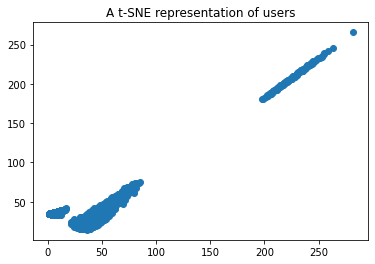

In [243]:
# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1st feature: ys
ys = tsne_features[:,1]

# Scatter plot, coloring by variety_numbers
plt.scatter(xs,ys)
plt.title('A t-SNE representation of users')
plt.show()

#### Note: 
- There are 3 distinct clusters visible which might correspond to the non-payer, payer and whales that we have seen earlier
- There is no meaning that the axis in a t-SNE plot
- The point above is just to explore and form an intuition of the underlying data

## Apply PCA to reduce dimenionality

In [25]:
# Fit PCA capturing 90% variance
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)
pca.fit(scaled_data)


PCA(n_components=0.9)

In [229]:
pca.n_components_

44

#### 44 PCs are created capturing 90% information

In [226]:
perc_variances = pca.explained_variance_[:]/sum(pca.explained_variance_[:])


#### Plot variances of PCs generated

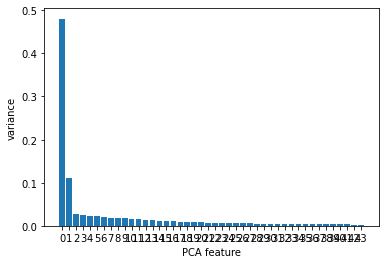

In [218]:
perc_variances=pca.explained_variance_[:]/sum(pca.explained_variance_[:])
features = range(pca.n_components_)
plt.bar(features[:], perc_variances)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

#### Note: Huge variances captured by 1st and followed by 2nd PC

#### Plot the cumulative sum of variances to identify the number of PCs to consider

Text(0.5, 1.0, 'Cumulative sum of variance across number of clusters')

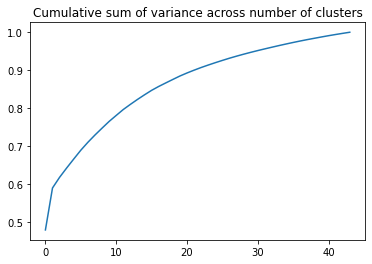

In [219]:
plt.plot(np.cumsum(perc_variances))
plt.title('Cumulative sum of variance across number of clusters')

#### Note: The above graph does not show early saturation indicating information gain across all 44 components we are selecting 

In [26]:
pca_data=pca.transform(scaled_data)
pca_data.shape

(30000, 44)

### K-means clustering

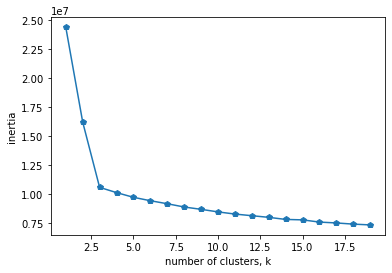

In [27]:
from sklearn.cluster import KMeans
inertias = []

# Creating 10 K-Mean models while varying the number of clusters (k)
for k in range(1,20):
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(pca_data)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(range(1,20), inertias, '-p')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.show()

#### Above plot shows knee at 3 clusters; zooming in further by looking at the plot from 2nd/3rd cluster on 

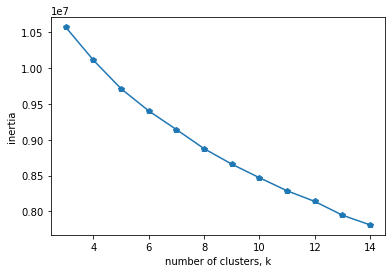

In [302]:
plt.plot(range(3,15), inertias[2:14], '-p')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.show()

#### Note:No clear elbow visible

### Create final segments with 4 clusters

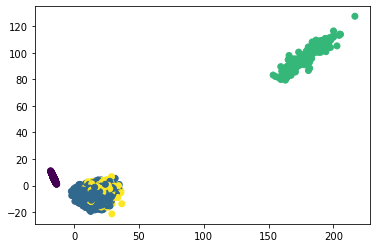

In [30]:
pca_df=pd.DataFrame(pca_data)
model = KMeans(n_clusters=4)
model.fit(pca_df)

labels = model.predict(pca_df)
plt.scatter(pca_df[0], pca_df[1], c=labels)
plt.show()

In [ ]:
kmeans_pca_df=pca_df
kmeans_pca_df['segments']=labels

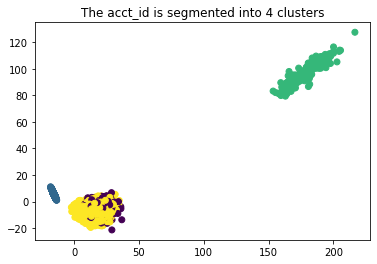

(30000, 45)

In [36]:
def PCA_kmeans(data):
    master_numpy = data.fillna(0).drop('acct_id',axis=1).to_numpy()
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans

    scaler = StandardScaler()
    scaled_data=scaler.fit_transform(master_numpy)

    pca = PCA(n_components=0.9)
    pca.fit(scaled_data)
    pca_data=pca.transform(scaled_data)

    kmeans = KMeans(n_clusters=4)
    kmeans.fit(pca_data)
    labels = model.predict(pca_data)

    plt.scatter(pca_df[0], pca_df[1], c=labels)
    plt.title('The acct_id is segmented into 4 clusters')
    plt.show()

    kmeans_pca_df=pd.DataFrame(pca_data)
    kmeans_pca_df['segments']=labels
    
    return kmeans_pca_df

PCA_kmeans(master_dtst).shape


In [35]:
len(labels)

30000

#### Incomplete: Trying out another method to get PCA: 
- Using CSR matrix from scipy and Truncated SVD to carry out PCA since we have a sparse matrix

In [158]:
import scipy as sp

In [159]:
# Convert data to a numpy array
master_csr = sp.sparse.csr_matrix(master_dtst.fillna(0).drop('acct_id',axis=1))

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
model_svd=TruncatedSVD(n_components=50)
SVD_components=model_svd.fit_transform(master_csr)
# model.transform()

In [ ]:
model_svd.explained_variance_.sort()

In [ ]:
features = range(50)
plt.bar(features[:], model_svd.explained_variance_[::-1][1:])
plt.xlabel('SVD feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()